# HEV Spare Parts Price Classification

_Final consolidated pipeline mirroring the demand workflow for price tiers_

## Environment & Imports

In [1]:

import warnings
warnings.filterwarnings("ignore")

import sys
import subprocess
import platform
import os
import json
import itertools
import hashlib
from pathlib import Path


def _ensure_import(module_name, pip_name=None):
    try:
        return __import__(module_name)
    except ModuleNotFoundError:
        pkg = pip_name or module_name
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        return __import__(module_name)


_ensure_import('seaborn', 'seaborn')
_ensure_import('sklearn', 'scikit-learn')
_ensure_import('numpy', 'numpy')
_ensure_import('pandas', 'pandas')
_ensure_import('matplotlib', 'matplotlib')

system = platform.system()
machine = platform.machine().lower()
tf_pkg = 'tensorflow'
if system == 'Windows':
    tf_pkg = 'tensorflow-cpu'
elif system == 'Darwin' and 'arm' in machine:
    tf_pkg = 'tensorflow-macos'
_ensure_import('tensorflow', tf_pkg)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

os.environ["TF_DETERMINISTIC_OPS"] = "1"

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Configuration

In [2]:

# Configuration toggles
DROP_PART = False  # set True to drop part identifier from features
BLOCKLIST_FEATURES = {'on line price'}  # remove entries to include leak-prone columns
SPLIT_STRATEGY = 'random'  # options: 'random', 'group'

# Hyperparameter grids
GRID = {
    'num_layers':    [1, 2, 3],
    'units':         [64, 96, 128],
    'dropout_rate':  [0.0],
    'l2_reg':        [0.0, 1e-4, 1e-3],
    'learning_rate': [5e-4, 1e-3, 2.5e-3, 5e-3, 1e-2]
}

GRIDS_CLASSIC = {
    "svc_rbf": {"C": [0.5, 1.0, 3.0], "gamma": ["scale", "auto", 0.01]},
    "logreg":  {"C": [0.3, 1.0, 3.0, 10.0], "solver": ["lbfgs"], "max_iter": [3000]},
    "et":      {"n_estimators": [300, 500], "max_depth": [None, 30]},
    "sgd":     {"loss": ["log_loss"], "alpha": [1e-4, 5e-4, 1e-3], "max_iter": [3000], "random_state": [SEED]},
    "lda":     {"solver": ["svd"]},
}

MODEL_ZOO = {
    "svc_rbf": {
        "label": "SVC (RBF)",
        "factory": lambda p: SVC(**p),
        "style": "scale",
    },
    "logreg": {
        "label": "LogisticRegression",
        "factory": lambda p: LogisticRegression(multi_class="multinomial", **p),
        "style": "scale",
    },
    "et": {
        "label": "ExtraTrees",
        "factory": lambda p: ExtraTreesClassifier(random_state=SEED, n_jobs=-1, **p),
        "style": "tree",
    },
    "sgd": {
        "label": "SGDClassifier (log_loss)",
        "factory": lambda p: SGDClassifier(**p),
        "style": "scale",
    },
    "lda": {
        "label": "LinearDiscriminantAnalysis",
        "factory": lambda p: LDA(**p),
        "style": "scale",
    },
}
MODEL_KEYS = ["svc_rbf", "logreg", "et", "sgd", "lda"]

if SPLIT_STRATEGY not in {"random", "group"}:
    raise ValueError("SPLIT_STRATEGY must be 'random' or 'group'.")



## Data Loading & Profiling

In [3]:
price_env = os.environ.get("PRICE_DATA_PATH", "").strip()
candidates = [Path(price_env)] if price_env else []
candidates += [
    Path("data") / "Price.csv",
    Path("..") / "data" / "Price.csv",
]
file_path = next((p for p in candidates if p.exists()), None)
if file_path is None:
    raise FileNotFoundError("Could not find Price.csv. Set PRICE_DATA_PATH or place the file in data/ or ../data/.")

df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
print("Using file:", file_path.resolve())
print("Initial shape:", df.shape)

dup_count = df.duplicated().sum()
if dup_count:
    print(f"Dropping {dup_count} duplicate rows")
    df = df.drop_duplicates().reset_index(drop=True)

df['price'] = pd.to_numeric(df['price'], errors='coerce')
df = df.dropna(subset=['price']).reset_index(drop=True)
print("Shape after cleaning:", df.shape)

print("Price summary:")
print(df['price'].describe())

print("Feature dtypes:")
print(df.dtypes)

print("Unique value counts:")
print(df.nunique().sort_values())


Using file: /Users/yaeesh/hev-spareparts-ml/data/Price.csv
Initial shape: (7652, 16)
Dropping 60 duplicate rows
Shape after cleaning: (7592, 16)
Price summary:
count    7592.000000
mean      386.137455
std      1060.804969
min         1.000000
25%        50.000000
50%       100.000000
75%       230.000000
max      7716.000000
Name: price, dtype: float64
Feature dtypes:
car type                                              int64
made in                                               int64
number of cars in jordan                              int64
car age                                               int64
part                                                  int64
failure rate                                        float64
price of the car                                    float64
original/imitator                                     int64
new\used                                              int64
selling location                                      int64
service location (repair sho

In [4]:

# Feature engineering derived from domain ratios
epsilon = 1e-6
with np.errstate(divide='ignore', invalid='ignore'):
    df['repair_to_car_price'] = df['repair or replacement cost'] / (df['price of the car'] + epsilon)
    df['repair_to_price'] = df['repair or replacement cost'] / (df['price'] + epsilon)
    df['maintenance_to_price'] = df['car total maintenance cost average'] / (df['price'] + epsilon)

df.replace([np.inf, -np.inf], np.nan, inplace=True)



## Feature Taxonomy

In [5]:

cat_cols_raw = [
    'car type',
    'made in',
    'original/imitator',
    r'new\used',
    'selling location',
    'service location (repair shop/automotive company',
    'part'
]
num_cols_raw = [
    'number of cars in jordan',
    'car age',
    'failure rate',
    'price of the car',
    'repair or replacement cost',
    'critically',
    'car total maintenance cost average',
    'repair_to_car_price',
    'repair_to_price',
    'maintenance_to_price',
    'on line price'
]

cat_cols = list(cat_cols_raw)
if DROP_PART and 'part' in cat_cols:
    cat_cols.remove('part')

num_all = [c for c in num_cols_raw if c not in BLOCKLIST_FEATURES]

required_cols = cat_cols + num_all + ['price']
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing expected columns: {missing_cols}")

cat_cols_effective = cat_cols
X_all = df[cat_cols_effective + num_all].copy()
groups_all = df['part'].astype(str)

skewed_candidate = [
    'number of cars in jordan',
    'failure rate',
    'repair or replacement cost',
    'critically',
    'price of the car',
    'repair_to_car_price',
    'repair_to_price',
    'maintenance_to_price'
]
skewed_cols = [c for c in skewed_candidate if c in num_all]
other_num_cols = [c for c in num_all if c not in skewed_cols]

print("Categorical features:", cat_cols_effective)
print("Numeric features:", num_all)
print("Log-transform numeric features:", skewed_cols)



Categorical features: ['car type', 'made in', 'original/imitator', 'new\\used', 'selling location', 'service location (repair shop/automotive company', 'part']
Numeric features: ['number of cars in jordan', 'car age', 'failure rate', 'price of the car', 'repair or replacement cost', 'critically', 'car total maintenance cost average', 'repair_to_car_price', 'repair_to_price', 'maintenance_to_price']
Log-transform numeric features: ['number of cars in jordan', 'failure rate', 'repair or replacement cost', 'critically', 'price of the car', 'repair_to_car_price', 'repair_to_price', 'maintenance_to_price']


## Helper Functions

In [6]:

def compute_thresholds_from_train(price_series, q_low=0.33, q_high=0.66):
    q = price_series.quantile([q_low, q_high])
    return float(q.loc[q_low]), float(q.loc[q_high])

def bin_with_thresholds(price_series, low_thr, high_thr):
    return pd.cut(
        price_series,
        bins=[-np.inf, low_thr, high_thr, np.inf],
        labels=[0, 1, 2]
    ).astype(int)

def make_preprocessor(style: str) -> ColumnTransformer:
    if style == "scale":
        num_skew = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log1p', FunctionTransformer(np.log1p, validate=False)),
            ('scaler', StandardScaler())
        ])
        num_plain = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
    elif style == "tree":
        num_skew = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log1p', FunctionTransformer(np.log1p, validate=False))
        ])
        num_plain = Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ])
    else:
        raise ValueError(f"Unknown preprocessor style: {style}")

    try:
        cat = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
    except TypeError:
        cat = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])

    return ColumnTransformer(
        transformers=[
            ('num_skew', num_skew,   skewed_cols),
            ('num',      num_plain,  other_num_cols),
            ('cat',      cat,        cat_cols_effective)
        ],
        remainder='drop'
    )

def build_ann(input_dim, num_layers, units, dropout_rate, l2_reg, learning_rate, num_classes=3):
    tf.keras.backend.clear_session()
    model = Sequential()
    reg = regularizers.l2(l2_reg) if l2_reg and l2_reg > 0 else None
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(units, activation='relu', kernel_regularizer=reg, input_shape=(input_dim,)))
        else:
            model.add(Dense(units, activation='relu', kernel_regularizer=reg))
        if dropout_rate and dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def grid_dict_product(grid):
    keys = list(grid.keys())
    for values in itertools.product(*(grid[k] for k in keys)):
        yield dict(zip(keys, values))

def hash_rows(df_like):
    str_df = df_like.copy()
    for c in str_df.columns:
        if pd.api.types.is_numeric_dtype(str_df[c]):
            str_df[c] = str_df[c].astype(float).map(lambda x: f"{x:.12g}")
        else:
            str_df[c] = str_df[c].astype(str)
    concat = str_df.apply(lambda r: '||'.join(r.values.astype(str)), axis=1)
    return concat.map(lambda s: hashlib.md5(s.encode('utf-8')).hexdigest())


## Train/Test Split & Label Binning

In [7]:

if SPLIT_STRATEGY == 'group':
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, test_idx = next(gss.split(X_all, None, groups=groups_all))
else:
    global_low, global_high = compute_thresholds_from_train(df['price'])
    df['_temp_price_bin'] = bin_with_thresholds(df['price'], global_low, global_high)
    indices = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        indices,
        test_size=0.2,
        random_state=SEED,
        stratify=df['_temp_price_bin']
    )
    df = df.drop(columns=['_temp_price_bin'])

low_thr, high_thr = compute_thresholds_from_train(df['price'].iloc[train_idx])
df['price_bin'] = bin_with_thresholds(df['price'], low_thr, high_thr)
class_order = [0, 1, 2]

X_train_raw = X_all.iloc[train_idx].reset_index(drop=True)
X_test_raw  = X_all.iloc[test_idx].reset_index(drop=True)
y_train = df['price_bin'].iloc[train_idx].reset_index(drop=True)
y_test  = df['price_bin'].iloc[test_idx].reset_index(drop=True)

groups_train = groups_all.iloc[train_idx].reset_index(drop=True)
groups_test  = groups_all.iloc[test_idx].reset_index(drop=True)

print(f"Split strategy: {SPLIT_STRATEGY}")
print(f"Train size: {len(X_train_raw)} | Test size: {len(X_test_raw)}")



Split strategy: random
Train size: 6073 | Test size: 1519


In [8]:

print(f"Train thresholds => low: {low_thr:.2f}, high: {high_thr:.2f}")
print("Train distribution:")
print(y_train.value_counts().sort_index())
print("Test distribution:")
print(y_test.value_counts().sort_index())


Train thresholds => low: 55.00, high: 167.16
Train distribution:
price_bin
0    2016
1    2005
2    2052
Name: count, dtype: int64
Test distribution:
price_bin
0    504
1    502
2    513
Name: count, dtype: int64


In [9]:

train_hash = hash_rows(X_train_raw)
test_hash  = hash_rows(X_test_raw)
overlap = set(train_hash).intersection(set(test_hash))
print(f"Row-hash overlap between train and test using model features: {len(overlap)} rows")
if overlap:
    print("WARNING: Duplicate feature rows detected across splits. Investigate potential leakage.")


Row-hash overlap between train and test using model features: 0 rows


## ANN Hyperparameter Search

In [10]:

if SPLIT_STRATEGY == 'group':
    inner_splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    inner_args = {'groups': groups_train}
else:
    inner_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    inner_args = {}

inner_tr_idx, inner_val_idx = next(inner_splitter.split(X_train_raw, y_train, **inner_args))

X_inner_tr_raw = X_train_raw.iloc[inner_tr_idx]
X_inner_val_raw = X_train_raw.iloc[inner_val_idx]
y_inner_tr = y_train.iloc[inner_tr_idx]
y_inner_val = y_train.iloc[inner_val_idx]

pre_gs = make_preprocessor(style="scale")
X_inner_tr = pre_gs.fit_transform(X_inner_tr_raw).astype("float32")
X_inner_val = pre_gs.transform(X_inner_val_raw).astype("float32")
input_dim_inner = X_inner_tr.shape[1]

best_cfg = None
best_val_f1 = -np.inf
best_history = None

total_combos = int(np.prod([len(v) for v in GRID.values()]))
print(f"Starting ANN exhaustive grid search over {total_combos} combinations...")
for idx, cfg in enumerate(grid_dict_product(GRID), start=1):
    print(f"Config {idx}/{total_combos}: {cfg}")
    model_tmp = build_ann(
        input_dim=input_dim_inner,
        num_layers=cfg['num_layers'],
        units=cfg['units'],
        dropout_rate=cfg['dropout_rate'],
        l2_reg=cfg['l2_reg'],
        learning_rate=cfg['learning_rate'],
        num_classes=len(class_order)
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=0)

    history_tmp = model_tmp.fit(
        X_inner_tr, y_inner_tr,
        epochs=120,
        validation_data=(X_inner_val, y_inner_val),
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    y_val_pred = np.argmax(model_tmp.predict(X_inner_val, verbose=0), axis=1)
    f1 = f1_score(y_inner_val, y_val_pred, average='macro')
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_cfg = cfg
        best_history = history_tmp

print("Best ANN grid configuration (inner validation macro F1):", round(best_val_f1, 4))
print(best_cfg)



Starting ANN exhaustive grid search over 135 combinations...
Config 1/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0005}


Config 2/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


Config 3/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0025}


Config 4/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.005}


Config 5/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


Config 6/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0005}


Config 7/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


Config 8/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0025}


Config 9/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.005}


Config 10/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


Config 11/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0005}


Config 12/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.001}


Config 13/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0025}


Config 14/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.005}


Config 15/135: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.01}


Config 16/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0005}


Config 17/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


Config 18/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0025}


Config 19/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.005}


Config 20/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


Config 21/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0005}


Config 22/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


Config 23/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0025}


Config 24/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.005}


Config 25/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


Config 26/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0005}


Config 27/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.001}


Config 28/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0025}


Config 29/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.005}


Config 30/135: {'num_layers': 1, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.01}


Config 31/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0005}


Config 32/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


Config 33/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0025}


Config 34/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.005}


Config 35/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


Config 36/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0005}


Config 37/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


Config 38/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0025}


Config 39/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.005}


Config 40/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


Config 41/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0005}


Config 42/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.001}


Config 43/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0025}


Config 44/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.005}


Config 45/135: {'num_layers': 1, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.01}


Config 46/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0005}


Config 47/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


Config 48/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0025}


Config 49/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.005}


Config 50/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


Config 51/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0005}


Config 52/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


Config 53/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0025}


Config 54/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.005}


Config 55/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


Config 56/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0005}


Config 57/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.001}


Config 58/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0025}


Config 59/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.005}


Config 60/135: {'num_layers': 2, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.01}


Config 61/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0005}


Config 62/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


Config 63/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0025}


Config 64/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.005}


Config 65/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


Config 66/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0005}


Config 67/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


Config 68/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0025}


Config 69/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.005}


Config 70/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


Config 71/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0005}


Config 72/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.001}


Config 73/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0025}


Config 74/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.005}


Config 75/135: {'num_layers': 2, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.01}


Config 76/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0005}


Config 77/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


Config 78/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0025}


Config 79/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.005}


Config 80/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


Config 81/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0005}


Config 82/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


Config 83/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0025}


Config 84/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.005}


Config 85/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


Config 86/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0005}


Config 87/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.001}


Config 88/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0025}


Config 89/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.005}


Config 90/135: {'num_layers': 2, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.01}


Config 91/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0005}


Config 92/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


Config 93/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0025}


Config 94/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.005}


Config 95/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


Config 96/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0005}


Config 97/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


Config 98/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0025}


Config 99/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.005}


Config 100/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


Config 101/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0005}


Config 102/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.001}


Config 103/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0025}


Config 104/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.005}


Config 105/135: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.01}


Config 106/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0005}


Config 107/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


Config 108/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0025}


Config 109/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.005}


Config 110/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


Config 111/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0005}


Config 112/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


Config 113/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0025}


Config 114/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.005}


Config 115/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


Config 116/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0005}


Config 117/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.001}


Config 118/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0025}


Config 119/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.005}


Config 120/135: {'num_layers': 3, 'units': 96, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.01}


Config 121/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0005}


Config 122/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


Config 123/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.0025}


Config 124/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.005}


Config 125/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


Config 126/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0005}


Config 127/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


Config 128/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0025}


Config 129/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.005}


Config 130/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


Config 131/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0005}


Config 132/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.001}


Config 133/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0025}


Config 134/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.005}


Config 135/135: {'num_layers': 3, 'units': 128, 'dropout_rate': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.01}


Best ANN grid configuration (inner validation macro F1): 1.0
{'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0025}


## Final ANN Training & Evaluation

In [11]:

preprocessor = make_preprocessor(style="scale")
X_train_proc = preprocessor.fit_transform(X_train_raw).astype("float32")
X_test_proc  = preprocessor.transform(X_test_raw).astype("float32")
input_dim = X_train_proc.shape[1]

if SPLIT_STRATEGY == 'group':
    inner_splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    split_args = {'groups': groups_train}
else:
    inner_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    split_args = {}

inner_tr_idx2, inner_val_idx2 = next(inner_splitter.split(X_train_raw, y_train, **split_args))
X_tr2 = X_train_proc[inner_tr_idx2].astype("float32")
X_val2 = X_train_proc[inner_val_idx2].astype("float32")
y_tr2 = y_train.iloc[inner_tr_idx2]
y_val2 = y_train.iloc[inner_val_idx2]

model = build_ann(
    input_dim=input_dim,
    num_layers=best_cfg['num_layers'],
    units=best_cfg['units'],
    dropout_rate=best_cfg['dropout_rate'],
    l2_reg=best_cfg['l2_reg'],
    learning_rate=best_cfg['learning_rate'],
    num_classes=len(class_order)
)

class_weight = None
train_counts = y_tr2.value_counts().sort_index()
if train_counts.min() / train_counts.max() < 0.6:
    cw = compute_class_weight(class_weight='balanced', classes=np.array(class_order), y=y_tr2)
    class_weight = {cls: w for cls, w in zip(class_order, cw)}
    print("Using class weights:", class_weight)

early_stop_final = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
reduce_lr_final  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)

history = model.fit(
    X_tr2, y_tr2,
    epochs=160,
    validation_data=(X_val2, y_val2),
    callbacks=[early_stop_final, reduce_lr_final],
    verbose=0,
    class_weight=class_weight
)



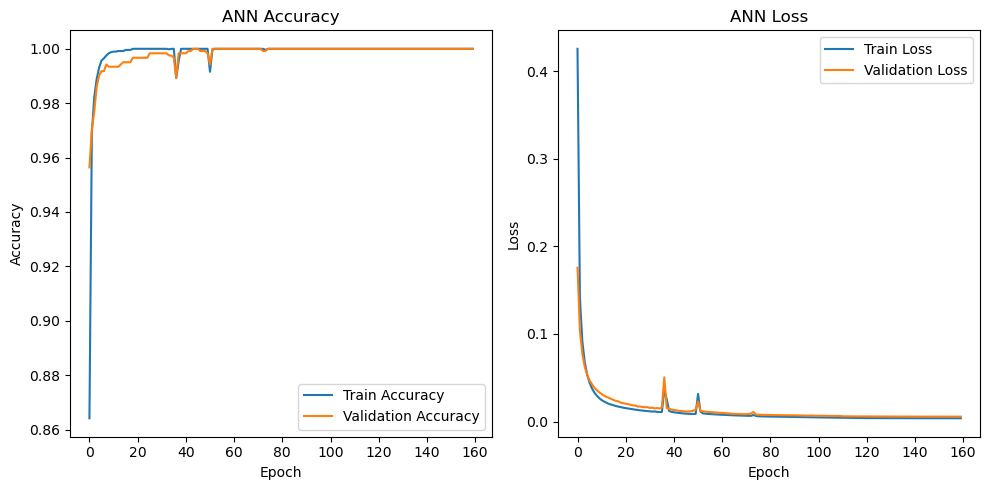

In [12]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.tight_layout()
plt.show()


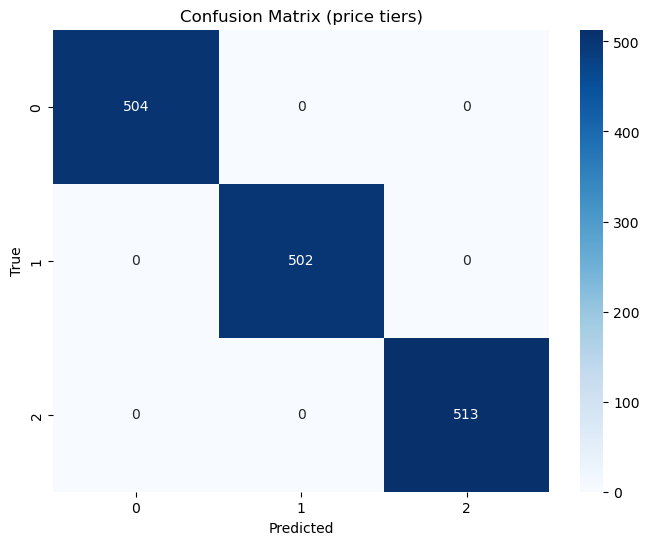

Classification report (price tiers):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       504
           1       1.00      1.00      1.00       502
           2       1.00      1.00      1.00       513

    accuracy                           1.00      1519
   macro avg       1.00      1.00      1.00      1519
weighted avg       1.00      1.00      1.00      1519

Test Accuracy: 1.0000
Macro F1:      1.0000
Best ANN configuration: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0025}
Thresholds kept in-session: low=55.00, high=167.16


In [13]:

y_pred_proba = model.predict(X_test_proc, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y_test.to_numpy()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_order, yticklabels=class_order)
plt.title('Confusion Matrix (price tiers)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

print("Classification report (price tiers):")
print(classification_report(y_true, y_pred, zero_division=0))
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1:      {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Best ANN configuration: {best_cfg}")
print(f"Thresholds kept in-session: low={low_thr:.2f}, high={high_thr:.2f}")


## Grouped Cross-Validation (ANN)

In [14]:

num_folds = 5
if SPLIT_STRATEGY == 'group':
    cv_splitter = GroupKFold(n_splits=num_folds)
    split_iter = cv_splitter.split(X_all, None, groups=groups_all)
else:
    cv_splitter = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    split_iter = cv_splitter.split(X_all, df['price_bin'])

acc_per_fold, f1_per_fold, loss_per_fold = [], [], []
for fold_no, (tr_idx, val_idx) in enumerate(split_iter, start=1):
    X_tr_raw, X_val_raw = X_all.iloc[tr_idx], X_all.iloc[val_idx]
    price_tr = df['price'].iloc[tr_idx]
    price_val = df['price'].iloc[val_idx]

    low_f, high_f = compute_thresholds_from_train(price_tr)
    y_tr_f = bin_with_thresholds(price_tr, low_f, high_f)
    y_val_f = bin_with_thresholds(price_val, low_f, high_f)

    pre_fold = make_preprocessor(style="scale")
    X_tr = pre_fold.fit_transform(X_tr_raw).astype("float32")
    X_val = pre_fold.transform(X_val_raw).astype("float32")

    model_fold = build_ann(
        input_dim=X_tr.shape[1],
        num_layers=best_cfg['num_layers'],
        units=best_cfg['units'],
        dropout_rate=best_cfg['dropout_rate'],
        l2_reg=best_cfg['l2_reg'],
        learning_rate=best_cfg['learning_rate'],
        num_classes=len(class_order)
    )

    early_stop_cv = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    reduce_lr_cv  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=0)

    model_fold.fit(
        X_tr, y_tr_f,
        epochs=120,
        validation_data=(X_val, y_val_f),
        callbacks=[early_stop_cv, reduce_lr_cv],
        verbose=0
    )

    loss, acc = model_fold.evaluate(X_val, y_val_f, verbose=0)
    y_val_pred = np.argmax(model_fold.predict(X_val, verbose=0), axis=1)
    f1 = f1_score(y_val_f, y_val_pred, average='macro')

    print(f"Fold {fold_no}: Acc={acc*100:.2f}% | Loss={loss:.4f} | MacroF1={f1:.4f}")
    acc_per_fold.append(acc * 100)
    f1_per_fold.append(f1)
    loss_per_fold.append(loss)

print('\n' + '-'*72)
print(f'{"Grouped" if SPLIT_STRATEGY == "group" else "Stratified"} CV summary (unseen validation folds):')
print(f"Accuracy: mean {np.mean(acc_per_fold):.2f}%  (± {np.std(acc_per_fold):.2f})")
print(f"Macro F1: mean {np.mean(f1_per_fold):.4f} (± {np.std(f1_per_fold):.4f})")
print(f"Loss:     mean {np.mean(loss_per_fold):.4f}")
print('-'*72)



Fold 1: Acc=100.00% | Loss=0.0044 | MacroF1=1.0000


Fold 2: Acc=100.00% | Loss=0.0035 | MacroF1=1.0000


Fold 3: Acc=100.00% | Loss=0.0044 | MacroF1=1.0000


Fold 4: Acc=100.00% | Loss=0.0035 | MacroF1=1.0000


Fold 5: Acc=100.00% | Loss=0.0052 | MacroF1=1.0000

------------------------------------------------------------------------
Stratified CV summary (unseen validation folds):
Accuracy: mean 100.00%  (± 0.00)
Macro F1: mean 1.0000 (± 0.0000)
Loss:     mean 0.0042
------------------------------------------------------------------------


## Classical Model Benchmark

In [15]:

def fit_select_on_inner_classic(model_key, X_tr_raw, y_tr, groups_tr):
    if SPLIT_STRATEGY == 'group':
        inner = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
        split_gen = inner.split(X_tr_raw, y_tr, groups=groups_tr)
    else:
        inner = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
        split_gen = inner.split(X_tr_raw, y_tr)

    inner_tr_idx, inner_val_idx = next(split_gen)

    X_inner_tr_raw = X_tr_raw.iloc[inner_tr_idx]
    X_inner_val_raw = X_tr_raw.iloc[inner_val_idx]
    y_inner_tr = y_tr.iloc[inner_tr_idx]
    y_inner_val = y_tr.iloc[inner_val_idx]

    spec = MODEL_ZOO[model_key]
    grid = GRIDS_CLASSIC[model_key]
    style = spec['style']

    pre = make_preprocessor(style)
    X_inner_tr = pre.fit_transform(X_inner_tr_raw)
    X_inner_val = pre.transform(X_inner_val_raw)

    best_f1 = -np.inf
    best_params = None

    for params in grid_dict_product(grid):
        est = spec['factory'](params)
        est.fit(X_inner_tr, y_inner_tr)
        y_val_pred = est.predict(X_inner_val)
        f1 = f1_score(y_inner_val, y_val_pred, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_params = params

    return best_params, best_f1

records = []

for key in MODEL_KEYS:
    label = MODEL_ZOO[key]['label']
    print()
    print(f"=== {label} ({key}) ===")

    best_params, inner_f1 = fit_select_on_inner_classic(key, X_train_raw, y_train, groups_train)
    print(f"Selected params: {best_params} | Inner macro F1={inner_f1:.4f}")

    pre = make_preprocessor(MODEL_ZOO[key]['style'])
    X_train_cls = pre.fit_transform(X_train_raw)
    X_test_cls  = pre.transform(X_test_raw)

    est = MODEL_ZOO[key]['factory'](best_params)
    est.fit(X_train_cls, y_train)

    y_pred_cls = est.predict(X_test_cls)
    acc = accuracy_score(y_test, y_pred_cls)
    f1m = f1_score(y_test, y_pred_cls, average='macro')

    print(f"Test Accuracy={acc:.4f} | Test Macro F1={f1m:.4f}")
    print(classification_report(y_test, y_pred_cls, zero_division=0))

    records.append(
        {
            "key": key,
            "model": label,
            "best_params": best_params,
            "inner_macro_f1": round(inner_f1, 4),
            "test_accuracy": round(acc, 4),
            "test_macro_f1": round(f1m, 4),
        }
    )




=== SVC (RBF) (svc_rbf) ===


Selected params: {'C': 3.0, 'gamma': 'scale'} | Inner macro F1=0.9934


Test Accuracy=0.9980 | Test Macro F1=0.9980
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       504
           1       1.00      1.00      1.00       502
           2       1.00      1.00      1.00       513

    accuracy                           1.00      1519
   macro avg       1.00      1.00      1.00      1519
weighted avg       1.00      1.00      1.00      1519


=== LogisticRegression (logreg) ===


Selected params: {'C': 3.0, 'solver': 'lbfgs', 'max_iter': 3000} | Inner macro F1=0.9984


Test Accuracy=0.9967 | Test Macro F1=0.9967
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       504
           1       0.99      1.00      1.00       502
           2       1.00      0.99      1.00       513

    accuracy                           1.00      1519
   macro avg       1.00      1.00      1.00      1519
weighted avg       1.00      1.00      1.00      1519


=== ExtraTrees (et) ===


Selected params: {'n_estimators': 300, 'max_depth': None} | Inner macro F1=0.9983


Test Accuracy=1.0000 | Test Macro F1=1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       504
           1       1.00      1.00      1.00       502
           2       1.00      1.00      1.00       513

    accuracy                           1.00      1519
   macro avg       1.00      1.00      1.00      1519
weighted avg       1.00      1.00      1.00      1519


=== SGDClassifier (log_loss) (sgd) ===
Selected params: {'loss': 'log_loss', 'alpha': 0.0001, 'max_iter': 3000, 'random_state': 42} | Inner macro F1=0.9809


Test Accuracy=0.9789 | Test Macro F1=0.9788
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       504
           1       0.98      0.96      0.97       502
           2       0.98      1.00      0.99       513

    accuracy                           0.98      1519
   macro avg       0.98      0.98      0.98      1519
weighted avg       0.98      0.98      0.98      1519


=== LinearDiscriminantAnalysis (lda) ===


Selected params: {'solver': 'svd'} | Inner macro F1=0.9114
Test Accuracy=0.8953 | Test Macro F1=0.8967
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       504
           1       0.80      0.91      0.85       502
           2       0.96      0.88      0.92       513

    accuracy                           0.90      1519
   macro avg       0.90      0.90      0.90      1519
weighted avg       0.90      0.90      0.90      1519



In [16]:

results = pd.DataFrame.from_records(records)
results_sorted = results.sort_values([
    "test_macro_f1", "test_accuracy"
], ascending=False).reset_index(drop=True)

print("\n=== Ranked results (outer test) ===")
print(results_sorted[["model", "test_macro_f1", "test_accuracy", "inner_macro_f1", "best_params"]])



=== Ranked results (outer test) ===
                        model  test_macro_f1  test_accuracy  inner_macro_f1  \
0                  ExtraTrees         1.0000         1.0000          0.9983   
1                   SVC (RBF)         0.9980         0.9980          0.9934   
2          LogisticRegression         0.9967         0.9967          0.9984   
3    SGDClassifier (log_loss)         0.9788         0.9789          0.9809   
4  LinearDiscriminantAnalysis         0.8967         0.8953          0.9114   

                                         best_params  
0           {'n_estimators': 300, 'max_depth': None}  
1                       {'C': 3.0, 'gamma': 'scale'}  
2    {'C': 3.0, 'solver': 'lbfgs', 'max_iter': 3000}  
3  {'loss': 'log_loss', 'alpha': 0.0001, 'max_ite...  
4                                  {'solver': 'svd'}  


## Feature Leakage Audit

In [17]:

def single_feature_cv_score(feature_name):
    if feature_name in cat_cols_effective:
        try:
            ohe = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
        except TypeError:
            ohe = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
            ])
        pipe = Pipeline([('ohe', ohe),
                         ('clf', LogisticRegression(max_iter=2000, multi_class='multinomial'))])
        X_feat = df[[feature_name]].astype(str)
    else:
        steps = [('imputer', SimpleImputer(strategy='median'))]
        if feature_name in skewed_cols:
            steps.append(('log1p', FunctionTransformer(np.log1p, validate=False)))
        steps.append(('scaler', StandardScaler()))
        steps.append(('clf', LogisticRegression(max_iter=2000, multi_class='multinomial')))
        pipe = Pipeline(steps)
        X_feat = df[[feature_name]].copy()

    if SPLIT_STRATEGY == 'group':
        splitter = GroupKFold(n_splits=5)
        split_iter = splitter.split(X_all, None, groups=groups_all)
    else:
        splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        split_iter = splitter.split(X_all, df['price_bin'])

    f1_scores = []
    for tr_idx, val_idx in split_iter:
        price_tr = df['price'].iloc[tr_idx]
        price_val = df['price'].iloc[val_idx]
        low_f, high_f = compute_thresholds_from_train(price_tr)
        y_tr_f = bin_with_thresholds(price_tr, low_f, high_f)
        y_val_f = bin_with_thresholds(price_val, low_f, high_f)

        X_tr_f = X_feat.iloc[tr_idx]
        X_val_f = X_feat.iloc[val_idx]
        pipe.fit(X_tr_f, y_tr_f)
        y_val_pred = pipe.predict(X_val_f)
        f1_scores.append(f1_score(y_val_f, y_val_pred, average='macro'))

    return np.mean(f1_scores)

features_to_audit = cat_cols_effective + num_all
audit_results = []
print()
print('Running single-feature leakage audit (macro F1 per feature)...')
for feat in features_to_audit:
    score = single_feature_cv_score(feat)
    audit_results.append((feat, score))
audit_results.sort(key=lambda x: x[1], reverse=True)
print('Top 10 features by single-feature macro F1:')
for name, sc in audit_results[:10]:
    print(f"{name:45s} {sc:.4f}")

suspicious = [(n, s) for n, s in audit_results if s >= 0.99]
if suspicious:
    print()
    print('WARNING: These features alone achieve near-perfect classification under the current split strategy:')
    for n, s in suspicious:
        print(f"  - {n}: macro F1 {s:.4f}")
    print('Review whether they encode target information directly or leak future knowledge.')




Running single-feature leakage audit (macro F1 per feature)...


Top 10 features by single-feature macro F1:
maintenance_to_price                          0.8298
part                                          0.6981
repair_to_price                               0.6013
repair or replacement cost                    0.5050
repair_to_car_price                           0.4566
selling location                              0.3735
new\used                                      0.3246
critically                                    0.3167
service location (repair shop/automotive company 0.3049
car type                                      0.2946


## SHAP Explanations

In [18]:

import sys
import subprocess
import os
import platform
from pathlib import Path


def _ensure_import(module_name, pip_name=None):
    try:
        return __import__(module_name)
    except ModuleNotFoundError:
        pkg = pip_name or module_name
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        return __import__(module_name)


shap = _ensure_import('shap')
print('shap version:', getattr(shap, '__version__', 'unknown'))

_ensure_import('numpy')
_ensure_import('pandas')

tf_pkg = 'tensorflow'
system = platform.system()
machine = platform.machine().lower()
if system == 'Windows':
    tf_pkg = 'tensorflow-cpu'
elif system == 'Darwin' and 'arm' in machine:
    tf_pkg = 'tensorflow-macos'
_ensure_import('tensorflow', tf_pkg)
_ensure_import('sklearn', 'scikit-learn')

import numpy as np  # noqa: E402
import pandas as pd  # noqa: E402
import tensorflow as tf  # noqa: E402
from sklearn.model_selection import GroupShuffleSplit  # noqa: E402

required_globals = ['model', 'preprocessor', 'cat_cols_effective', 'num_all']
missing = [name for name in required_globals if name not in globals()]
if missing:
    raise RuntimeError(f"Run the training cells first to define: {missing}")

seed = int(globals().get('SEED', 42))
np.random.seed(seed)
tf.random.set_seed(seed)

cat_cols_effective = globals()['cat_cols_effective']
num_all = globals()['num_all']
model = globals()['model']
preprocessor = globals()['preprocessor']

price_env = os.environ.get('PRICE_DATA_PATH', '').strip()
candidates = [Path(p) for p in [price_env] if p] + [
    Path('data') / 'Price.csv',
    Path('..') / 'data' / 'Price.csv',
]
file_path = next((p for p in candidates if p.exists()), None)
if file_path is None:
    raise FileNotFoundError('Could not find Price.csv for SHAP. Set PRICE_DATA_PATH or place it in data/ or ../data/.')

df_price = pd.read_csv(file_path)
df_price.columns = df_price.columns.str.strip()
df_price['price'] = pd.to_numeric(df_price['price'], errors='coerce')
df_price = df_price.dropna(subset=['price']).reset_index(drop=True)

df_price = df_price.drop_duplicates().reset_index(drop=True)


with np.errstate(divide='ignore', invalid='ignore'):
    df_price['repair_to_car_price'] = df_price['repair or replacement cost'] / (df_price['price of the car'] + 1e-6)
    df_price['repair_to_price'] = df_price['repair or replacement cost'] / (df_price['price'] + 1e-6)
    df_price['maintenance_to_price'] = df_price['car total maintenance cost average'] / (df_price['price'] + 1e-6)
df_price.replace([np.inf, -np.inf], np.nan, inplace=True)

required_cols = set(cat_cols_effective + num_all + ['part', 'price'])
missing_cols = sorted(required_cols - set(df_price.columns))
if missing_cols:
    raise ValueError(f'Dataset missing expected columns: {missing_cols}')

X_all_price = df_price[cat_cols_effective + num_all].copy()
groups_all_price = df_price['part'].astype(str)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
train_idx_shap, test_idx_shap = next(gss.split(X_all_price, None, groups=groups_all_price))

X_train_raw_shap = X_all_price.iloc[train_idx_shap]
X_test_raw_shap = X_all_price.iloc[test_idx_shap]

X_train_proc_shap = preprocessor.transform(X_train_raw_shap).astype("float32")
X_test_proc_shap = preprocessor.transform(X_test_raw_shap).astype("float32")

print('Reused in-memory model and preprocessor for SHAP computation.')
print('  X_train_proc shape:', getattr(X_train_proc_shap, 'shape', None))
print('  X_test_proc shape :', getattr(X_test_proc_shap, 'shape', None))


shap version: 0.46.0
Reused in-memory model and preprocessor for SHAP computation.
  X_train_proc shape: (5720, 62)
  X_test_proc shape : (1872, 62)


In [19]:

def get_feature_names(preprocessor):
    try:
        names = preprocessor.get_feature_names_out()
        return [str(n).replace('num_skew__', '').replace('num__', '').replace('cat__', '') for n in names]
    except Exception:
        names = []
        for name, trans, cols in preprocessor.transformers_:
            if name == 'remainder' and trans == 'drop':
                continue
            if name in ('num_skew', 'num'):
                names.extend(list(cols))
            elif name == 'cat':
                try:
                    ohe = trans.named_steps.get('ohe')
                    categories = ohe.categories_
                    for col, cats in zip(cols, categories):
                        for cat in cats:
                            names.append(f'{col}={cat}')
                except Exception:
                    names.extend(list(cols))
            else:
                if isinstance(cols, list):
                    names.extend(list(cols))
        return names

feature_names = get_feature_names(preprocessor)
print('n_features:', len(feature_names))
print('first 10:', feature_names[:10])


n_features: 62
first 10: ['number of cars in jordan', 'failure rate', 'repair or replacement cost', 'critically', 'price of the car', 'repair_to_car_price', 'repair_to_price', 'maintenance_to_price', 'car age', 'car total maintenance cost average']


In [20]:

import platform

rng = np.random.RandomState(SEED)
X_bg = X_train_proc_shap
X_eval = X_test_proc_shap if 'X_test_proc_shap' in globals() else X_train_proc_shap

bg_size = min(100, X_bg.shape[0])
explain_size = min(200, X_eval.shape[0])
bg_idx = rng.choice(X_bg.shape[0], size=bg_size, replace=False)
explain_idx = rng.choice(X_eval.shape[0], size=explain_size, replace=False)

background = X_bg[bg_idx]
X_explain = X_eval[explain_idx]

if hasattr(background, 'toarray'):
    background = background.toarray()
if hasattr(X_explain, 'toarray'):
    X_explain = X_explain.toarray()


def _run_kernel_explainer(nsamples=100):
    f = lambda x: model.predict(x, verbose=0)
    explainer_loc = shap.KernelExplainer(f, background)
    values = explainer_loc.shap_values(X_explain, nsamples=nsamples)
    return explainer_loc, values

prefer_kernel = (platform.system() == 'Darwin' and platform.machine().lower().startswith('arm'))

if prefer_kernel:
    print('Using KernelExplainer on Apple Silicon for stability.')
    explainer, shap_values = _run_kernel_explainer()
    method = 'KernelExplainer'
else:
    try:
        explainer = shap.DeepExplainer(model, background)
        shap_values = explainer.shap_values(X_explain)
        method = 'DeepExplainer'
    except Exception as err:
        print('DeepExplainer failed, falling back to KernelExplainer:', err)
        explainer, shap_values = _run_kernel_explainer()
        method = 'KernelExplainer'

print('SHAP explainer:', method)

_shap_values = shap_values
_X_explain = X_explain
_background = background


Using KernelExplainer on Apple Silicon for stability.


  0%|          | 0/200 [00:00<?, ?it/s]

SHAP explainer: KernelExplainer


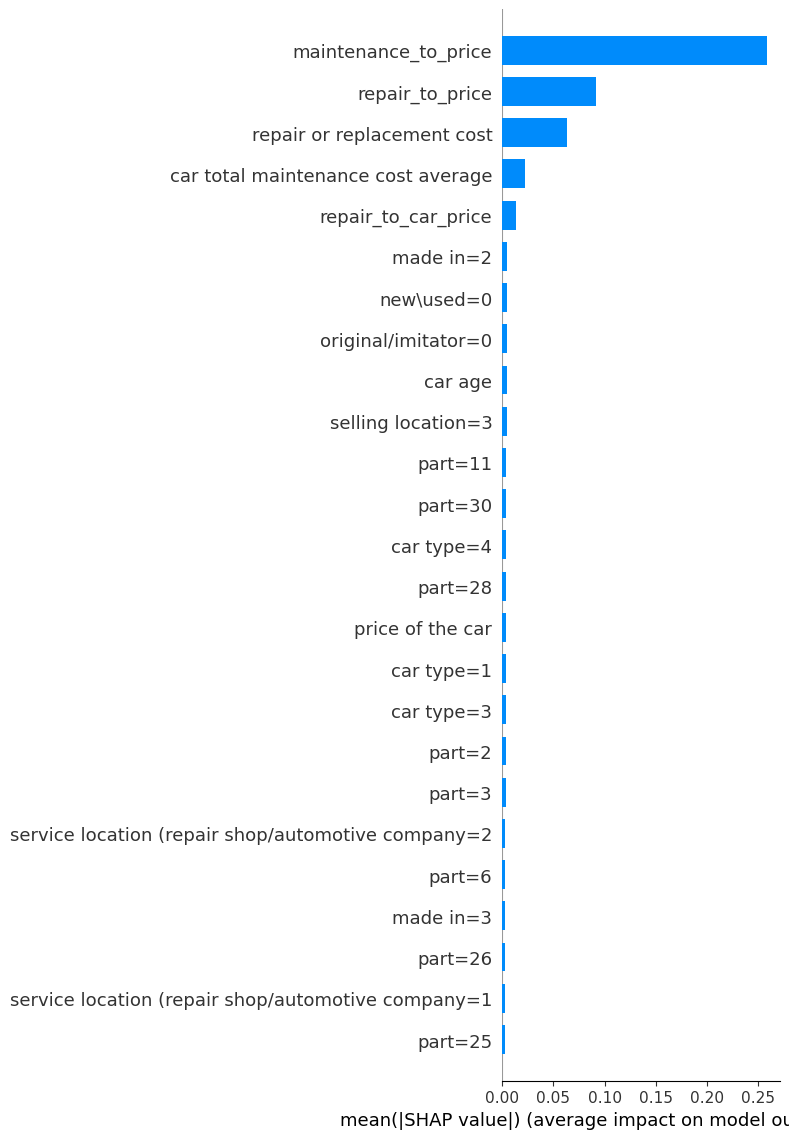

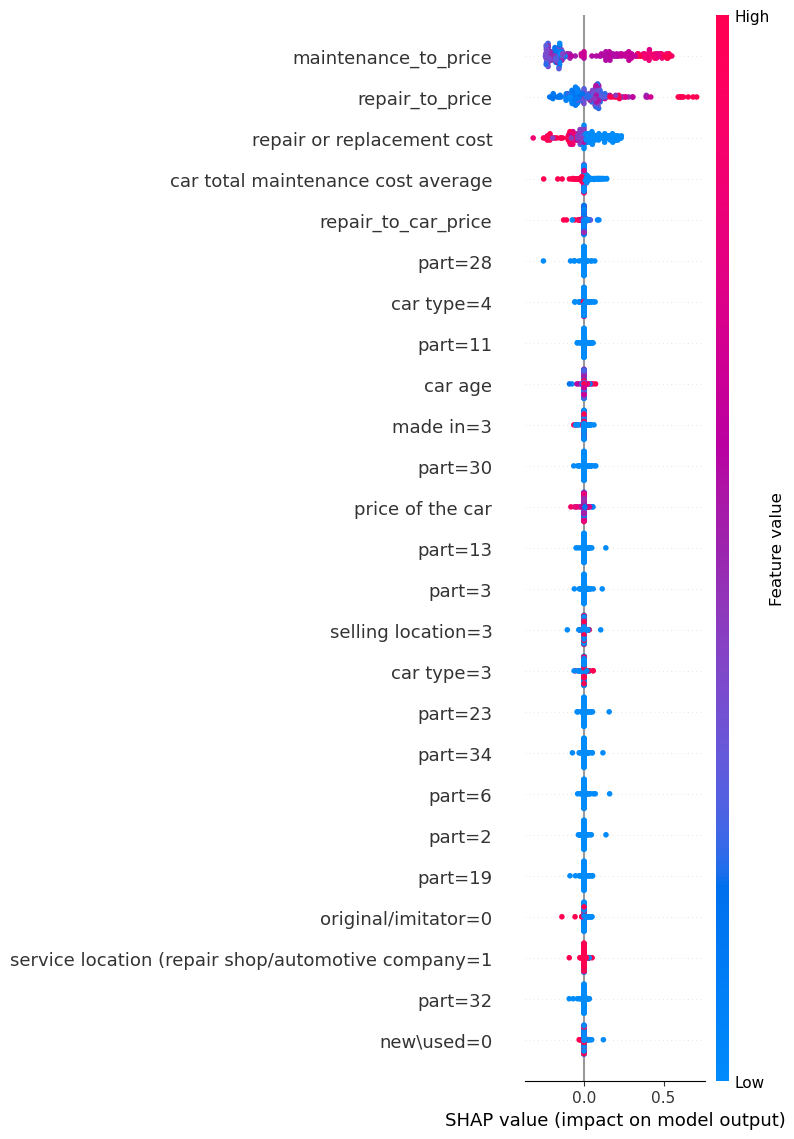

Displayed SHAP beeswarm plot for low_price; top features listed above (not saved).


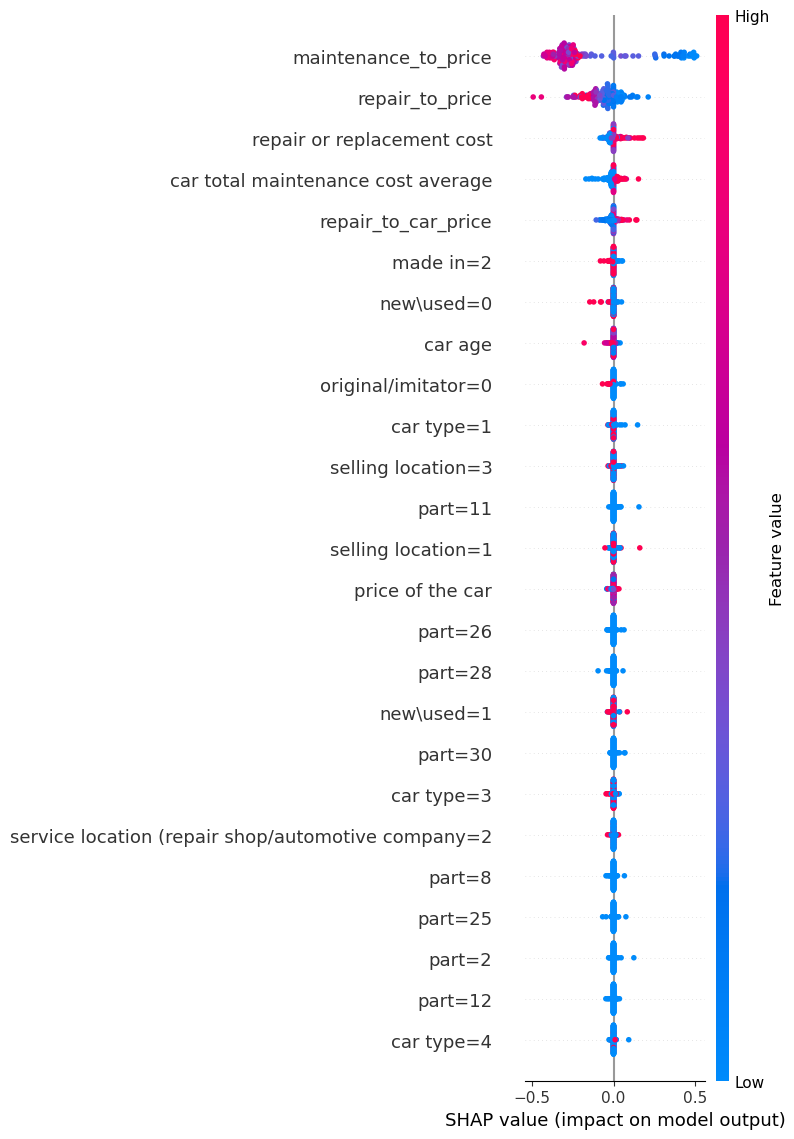

Displayed SHAP beeswarm plot for high_price; top features listed above (not saved).
Displayed SHAP summary plot and feature importance details in notebook (saved to figures/).
Saved files:
figures/price_shap_summary.png
figures/price_shap_low_price.png
figures/price_shap_high_price.png


In [21]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

figures_dir = Path('figures')
figures_dir.mkdir(exist_ok=True)

sv_raw = _shap_values
X_explain = _X_explain.toarray() if hasattr(_X_explain, 'toarray') else _X_explain

if isinstance(sv_raw, list):
    shap_array = np.stack([np.array(s) for s in sv_raw], axis=-1)
else:
    shap_array = np.array(sv_raw)
    if shap_array.ndim == 2:
        shap_array = shap_array[..., np.newaxis]

_shap_array = shap_array
shap_abs = np.abs(shap_array).mean(axis=-1)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_abs, X_explain, feature_names=feature_names, plot_type='bar', show=False, max_display=25)
plt.tight_layout()
summary_path = figures_dir / 'price_shap_summary.png'
plt.savefig(summary_path, dpi=300, bbox_inches='tight')
plt.show()

class_order = globals().get('class_order', list(range(shap_array.shape[-1])))
class_indices = {cls: idx for idx, cls in enumerate(class_order) if idx < shap_array.shape[-1]}
target_classes = {
    'low_price': 0,
    'high_price': 2,
}

for label, cls_id in target_classes.items():
    if cls_id not in class_indices:
        continue
    cls_idx = class_indices[cls_id]
    shap_class = shap_array[..., cls_idx]

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_class, X_explain, feature_names=feature_names, show=False, max_display=25)
    plt.tight_layout()
    beeswarm_path = figures_dir / f'price_shap_{label}.png'
    plt.savefig(beeswarm_path, dpi=300, bbox_inches='tight')
    plt.show()

    vals_cls = np.abs(shap_class).mean(axis=0)
    fi_cls = pd.Series(vals_cls, index=feature_names).sort_values(ascending=False)
    print(f"Displayed SHAP beeswarm plot for {label}; top features listed above (not saved).")

vals = shap_abs.mean(axis=0)
fi = pd.Series(vals, index=feature_names).sort_values(ascending=False)
print('Displayed SHAP summary plot and feature importance details in notebook (saved to figures/).')
print('Saved files:')
print(summary_path)
for label in target_classes:
    print(figures_dir / f'price_shap_{label}.png')
